# 01 - Explore and preprocess data
This notebook contains the code to investigate the datasets and preprocess images into a common sizes and color ranges for use with the classifier

In [1]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
colors = sns.color_palette()

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Extract label and bounding box information

In [3]:
# Extract the information from the mat files into json. 
# taken from http://www.a2ialab.com/lib/exe/fetch.php?media=public:scripts:svhn_dataextract_tojson.py.txt

def reformat_digitstruct():    
    for a in ['test', 'train']:
        filename = os.path.join(a, 'digitStruct.json')
        if os.path.isfile(filename):
            print("Already extracted %s, skipping" % filename)
        else:
            cmd = str.format("python svhn_dataextract_tojson.py -f {0}/digitStruct.mat -o {0}/digitStruct", a)
            print("Executing:%s" % cmd)
            result = os.system(cmd)
print('Extracting label and bounding box information')
reformat_digitstruct()
print('...done')

Extracting label and bounding box information
Already extracted test\digitStruct.json, skipping
Already extracted train\digitStruct.json, skipping
...done


In [4]:
# Extract the information from the json files
def load_file_meta(folder):
    results = []
    filename = os.path.join(folder, 'digitStruct.json')
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    for file_info in data:
        pic_info = {}
        pic_info['boxes'] = [{a : int(item[a]) for a in ['top', 'left', 'height', 'width']}
                             for item in file_info['boxes']]
        pic_info['label'] = np.array([int(item['label']) % 10 for item in file_info['boxes']])
        pic_info['filename'] = os.path.join(folder, file_info['filename'])
        
        # Calculate the bounding box of the numbers
        x1 = pic_info['boxes'][0]['left']
        x2 = pic_info['boxes'][-1]['left'] + pic_info['boxes'][-1]['width']
        
        y1 = np.min([b['top'] for b in pic_info['boxes']])
        y2 = np.max([b['top'] + b['height'] for b in pic_info['boxes']])
        
        pic_info['bbox'] = [x1, y1, x2, y2]
        pic_info['bbox_x'] = [x1, x2]
        pic_info['bbox_y'] = [y1, y2]
        pic_info['bbox_width'] = x2 - x1
        pic_info['bbox_height'] = y2 - y1
        pic_info['center_x'] = (x1 + x2) // 2
        pic_info['center_y'] = (y1 + y2) // 2
        pic_info['center'] = [pic_info['center_x'], pic_info['center_y']]
        
        results.append(pic_info)
    return results

test_info = load_file_meta('test')
train_info = load_file_meta('train')

## Investigate the lengths of digits

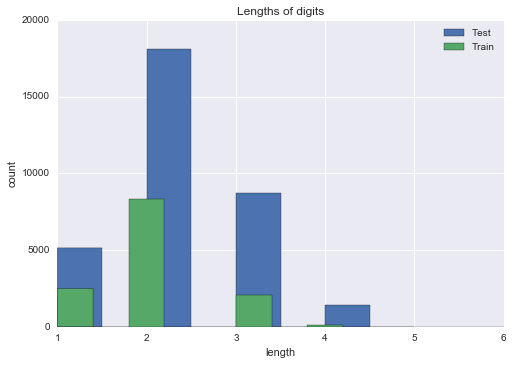

Training number length
len
1     5137
2    18130
3     8691
4     1434
5        9
6        1
Name: label, dtype: int64
Test number length
len
1    2483
2    8356
3    2081
4     146
5       2
Name: label, dtype: int64


In [5]:
# Let's investigate our dataset
def show_hist(data, **kwargs):    
    plt.hist(data, **kwargs)

df_train = pd.DataFrame(data=train_info)
df_test = pd.DataFrame(data=test_info)

df_train['len'] = df_train['label'].map(len)
df_test['len'] = df_test['label'].map(len)

show_hist(df_train['len'])
show_hist(df_test['len'])
plt.title('Lengths of digits')
plt.xlabel('length')
plt.ylabel('count')
plt.legend(['Test', 'Train'])
plt.show()

print("Training number length")
print(df_train.groupby('len').count()['label'])

print("Test number length")
print(df_test.groupby('len').count()['label'])

In [6]:
# Remove all images that have a length >= 4
df_train = df_train[df_train['label'].map(len) < 4]

## Investigate the quality of the images

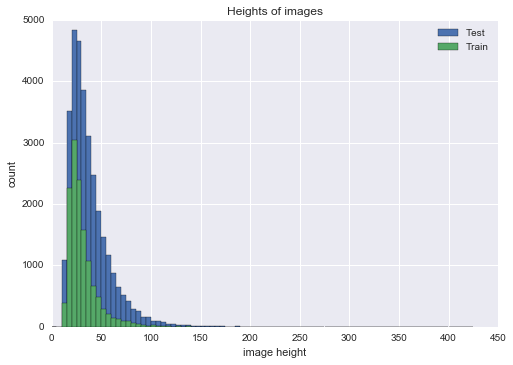

Train (min/max)
(9, 423)
Test (min/max)
(10, 222)
Train shape
(31958, 12)
Test shape
(13068, 12)


In [7]:
bin_size = 5
data = df_train['bbox_height']
bins=np.arange(0, max(data) + bin_size, bin_size)
show_hist(data, bins=bins)
show_hist(df_test['bbox_height'], bins=bins)
plt.title('Heights of images')
plt.xlabel('image height')
plt.ylabel('count')
plt.legend(['Test', 'Train'])
plt.show()

print("Train (min/max)")
print(np.min(df_train['bbox_height']), np.max(df_train['bbox_height']))
print("Test (min/max)")
print(np.min(df_test['bbox_height']), np.max(df_test['bbox_height']))


print("Train shape")
print(df_train.shape)
print("Test shape")
print(df_test.shape)

## Remove low quality images

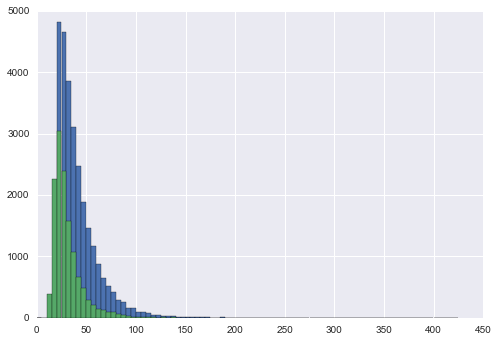

New training shape size
(27350L,)
(27350, 12)
Testing shape size
(13068, 12)


In [8]:
# Remove images with hieghts < 20
min_height = 20
df_train = df_train.loc[(df_train.bbox_height >= min_height)]

train_info = np.array(train_info)[df_train.index]
data = df_train['bbox_height'].values
show_hist(data, bins=bins)
show_hist(df_test['bbox_height'], bins=bins)
plt.show()

print("New training shape size")
print(train_info.shape)
print(df_train.shape)
print("Testing shape size")
print(df_test.shape)

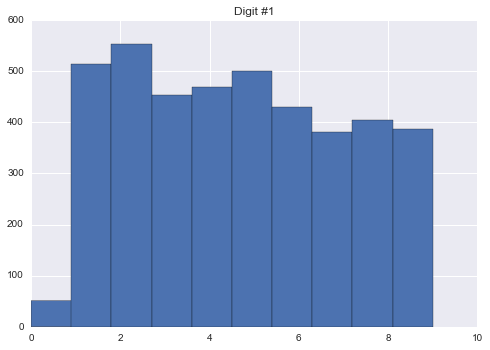

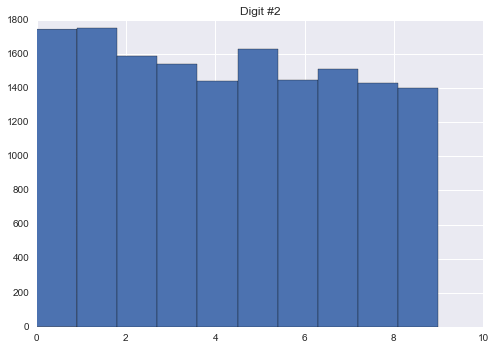

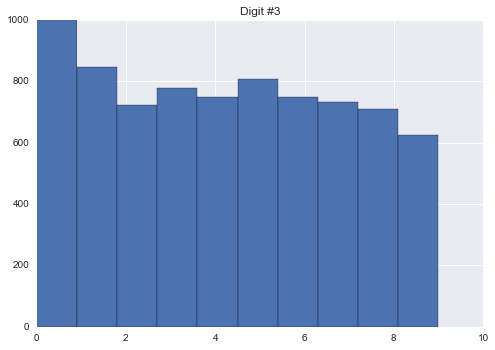

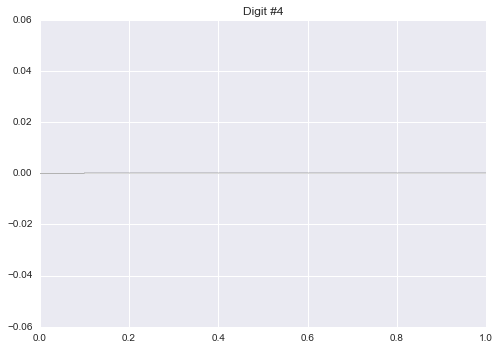

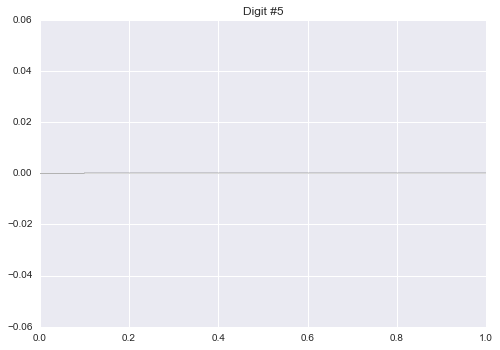

In [9]:
# Frequencies of digits in each position i.e 1-9
for i in range(5):
    df_train[df_train.len==i+1]['label'].apply(lambda x: x[i]).hist()
    plt.title("Digit #%d" % (i+1))
    plt.show()

## Preprocess the images in many threads

In [10]:
import os
from scipy import ndimage
import scipy.misc as spm
import scipy.ndimage as spn
from multiprocessing import Pool
from functools import partial

def pre_process_file(pic_info, show=False):
    img_height = 28 # Chosen to work with the Android camera app nicely
    img_width = 28
    image_file = pic_info['filename']

    if show:
        im = Image.open(pic_info['filename'])
        draw = ImageDraw.Draw(im)
        draw.rectangle(pic_info['bbox'])
        draw.rectangle([pic_info['center'][j]  + k for j, k in zip([0, 1, 0, 1], [-1, -1, 1, 1])])
        
    image_data = ndimage.imread(image_file, flatten=True).astype(float)
    
    # Calc a space around the digits as a buffer based on the y axis
    buff_size = int((pic_info['center_y'] - pic_info['bbox_y'][0]) * .4)
  
    # Create our ideal bounding box      
    x_start = pic_info['bbox_x'][0] - buff_size
    x_end = pic_info['bbox_x'][1] + buff_size
    
    y_start = pic_info['bbox_y'][0] - buff_size
    y_end = pic_info['bbox_y'][1] + buff_size
    
    dy, dx = y_end-y_start, x_end-x_start
    
    
    if dx > dy:
        y_start -= (dx - dy) // 2
        y_end = y_start + dx
    else:
        x_start -= (dy - dx) // 2
        x_end = x_start + dy
        
    dy, dx = y_end-y_start, x_end-x_start
        
    max_size = np.max([dx, dy])
    n_x_start, n_x_end = 0, dx
    n_y_start, n_y_end = 0, dy

    if x_start < 0:
        diff = 0-x_start
        n_x_start += diff
        x_start += diff        
        
    if y_start < 0:
        diff = 0-y_start
        n_y_start += diff
        y_start += diff
        
    if y_end > image_data.shape[0]:
        diff = y_end - image_data.shape[0]
        y_end -= diff
        n_y_end -= diff
                    
    if x_end > image_data.shape[1]:
        diff = x_end - image_data.shape[1]
        x_end -= diff
        n_x_end -= diff
        
    if show:
       draw.rectangle([x_start, y_start, x_end, y_end])
       
    square_output = np.ones([max_size, max_size]) * np.mean(image_data)
    
    square_output[n_y_start:n_y_end, n_x_start:n_x_end] = \
        image_data[y_start:y_end, x_start:x_end]
        
    factor = 1.0 * img_height / square_output.shape[0]
    img_zoomed = spn.interpolation.zoom(square_output, factor)
            
    img_colors = img_zoomed.astype(np.float32) - np.min(square_output)
    img_colors = img_colors / np.max(img_colors) - 0.5

    if show:
        print('*' * 60)
        print("Original", image_data.shape)
        print("Cropped", img_colors.shape)
        plt.figure(figsize=(3,3))
        plt.axis('off')
        plt.imshow(im)
        plt.show()
        print("Filename:%s" % pic_info['filename'])
        print("Label:%s" % pic_info['label'])
        print("Color range:", np.max(img_colors), np.min(img_colors))
        plt.imshow(img_colors, cmap=plt.get_cmap('jet'))
        plt.show()

    return img_colors, pic_info['label']

sns.set_style("white")
np.random.shuffle(train_info)

## Process the images using many threads

Processing images
[2 8]


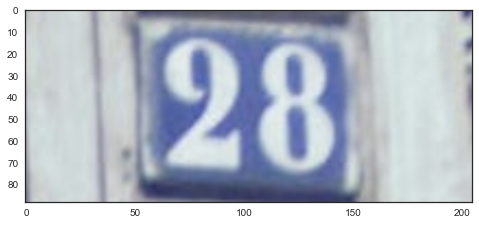

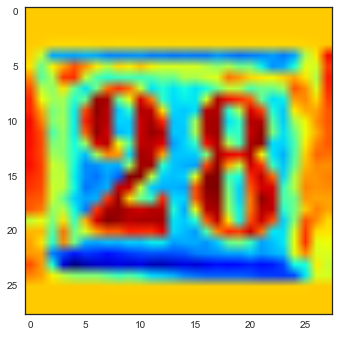

[3 4]


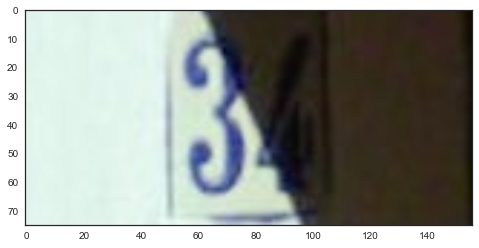

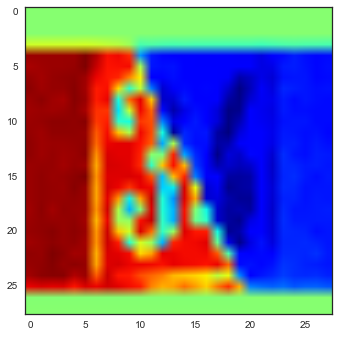

[5 4]


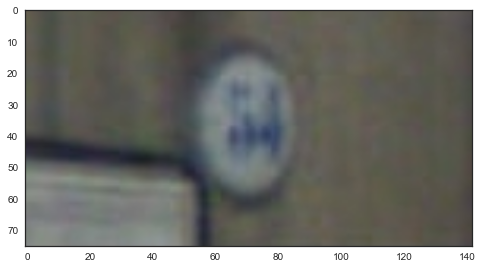

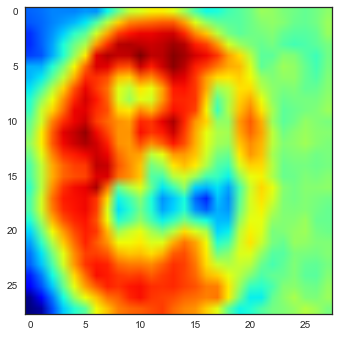

In [12]:
def generate_batch_parallel(pic_info_list, show=False):
    """Load the data for a single letter label."""
    
    # For linux use this
    if os.name != 'nt':
        pool = Pool()
        results = pool.map(partial(pre_process_file), pic_info_list[:1])
        pool.close()
        pool.join()
    else:
        # For windows use this
        results = [pre_process_file(a, show) for a in pic_info_list]
    
    imgs, labels = zip(*results)
    return np.array(imgs), np.array(labels)
    
print('Processing images')
np.random.shuffle(train_info)
tmp_pics, tmp_labels = generate_batch_parallel(train_info[:3])

for i, tmp_label in enumerate(tmp_labels):
    print(tmp_label)
    image_data = ndimage.imread(train_info[i]['filename'])
    plt.imshow(image_data)
    plt.show()
    plt.imshow(tmp_pics[i], cmap=plt.get_cmap('jet'))
    plt.show()
    

## Save the preprocessed images

In [13]:
for name, info in [('train', train_info), ('test', test_info)]:
    print('Generating:%s' % name)
    pics, labels = generate_batch_parallel(info)
    
    pickle_file = 'SVHN_%s.pickle' % name
    print("Saving:%s" % pickle_file)

    try:
      f = open(pickle_file, 'wb')
      save = {
        'dataset': pics,
        'labels': labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:%dmb' % (statinfo.st_size // 1024**2))
    
print("Done")

Generating:train
Saving:SVHN_train.pickle
Compressed pickle size:83mb
Generating:test
Saving:SVHN_test.pickle
Compressed pickle size:39mb
Done


c:\anaconda2\lib\site-packages\scipy\ndimage\interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
